In [25]:
nnunet_dataset_name = "Dataset010_ALL"

In [37]:
from src.config import config
import os
nnunet_train_dir = os.path.join(config["DATA_DIR"], "nnunet_raw", nnunet_dataset_name)
os.makedirs(nnunet_train_dir, exist_ok=True)
os.makedirs(os.path.join(nnunet_train_dir, "imagesTr"), exist_ok=True)
os.makedirs(os.path.join(nnunet_train_dir, "imagesTs"), exist_ok=True)
os.makedirs(os.path.join(nnunet_train_dir, "labelsTr"), exist_ok=True)
os.makedirs(os.path.join(nnunet_train_dir, "labelsTs"), exist_ok=True)

In [38]:
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(os.path.join(config["DATA_DIR"], "3D_train_npz_random_10percent_16G")) for f in filenames if os.path.splitext(f)[1] == '.npz']

len(files)


2985

In [39]:
import numpy as np
import nibabel as nib
import os
from multiprocessing import Pool
from functools import partial

def process_file(file_info, nnunet_train_dir, total_files):
    i, file = file_info
    subset = "Tr" if i < total_files * 0.8 else "Ts"
    #print(f"file : {os.path.basename(file)}, {i}/{total_files}")
    
    data = np.load( file, allow_pickle=True)
    imgs = data["imgs"]
    imgs_shape = np.array(imgs.shape)

    if np.any(imgs_shape==1) :#exclude 2d image for now, only 36 of them
        print("excluded")
        return None
    spacing = data["spacing"]
    #print(f"shape: {imgs.shape}")
    #print(f"spacing: {spacing}")
    spacing = spacing[2], spacing[1], spacing[0]  # Adjusting to match NIfTI format (z, y, x)
    
    # Create affine matrix
    affine = np.eye(4)
    affine[0, 0] = data["spacing"][0]
    affine[1, 1] = data["spacing"][1]
    affine[2, 2] = data["spacing"][2]
    
    # Save images
    nib_img = nib.Nifti1Image(imgs, affine=affine)
    nib.save(nib_img, os.path.join(nnunet_train_dir, "images"+subset, os.path.basename(file).replace(".npz", "_0000.nii.gz")))
    
    # Process and save ground truth
    gts = data["gts"]
    #print(np.unique(gts))
    #gts = (gts == 1).astype(np.int8)
    nib_gt = nib.Nifti1Image(gts, affine=affine)
    nib.save(nib_gt, os.path.join(nnunet_train_dir, "labels"+subset, os.path.basename(file).replace(".npz", ".nii.gz")))
    
    return file

# Main execution
# Create list of (index, filename) tuples
file_list = [(i, file) for i, file in enumerate(files)]

# Create partial function with fixed arguments
process_func = partial(process_file, 
                      nnunet_train_dir=nnunet_train_dir, 
                      total_files=len(files))

# Use 14 cores (leave 2 for system)
with Pool(processes=25) as pool:
    results = pool.map(process_func, file_list)

print(f"Processed {len(results)} files successfully")

excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
excluded
Processed 2985 files successfully


2388
Image shape: (9, 512, 512)


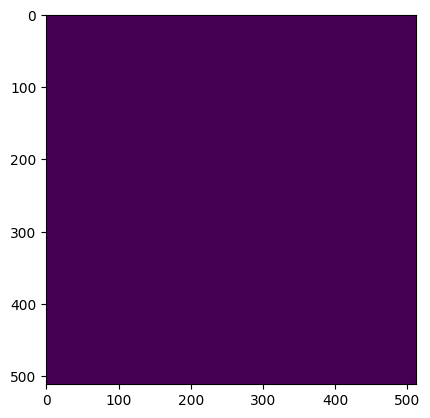

In [30]:
print(len(os.listdir(os.path.join(nnunet_train_dir,"labelsTr"))))
idx = 207
# visualize one of the images
import matplotlib.pyplot as plt
import nibabel as nib
from numpy import spacing
img_path = os.path.join(nnunet_train_dir, "labelsTr", os.listdir(os.path.join(nnunet_train_dir, "labelsTr"))[idx])
img = nib.load(img_path)
img_data = img.get_fdata()
spacing = img.header.get_zooms()
print(f"Image shape: {img_data.shape}")
gt1 = img_data == 3
plt.imshow(gt1.mean(axis=0),)


In [40]:
spacings = []
shapes = []
for i, f in enumerate(os.listdir(os.path.join(nnunet_train_dir,"labelsTr"))):
    if f.endswith(".nii.gz"):
        #print(f"Processing {i+1}/{len(os.listdir(os.path.join(nnunet_train_dir,'labelsTr')))}: {f}")
        img_path = os.path.join(nnunet_train_dir, "labelsTr", f)
        img = nib.load(img_path)
        img_data = img.get_fdata()
        spacing = img.header.get_zooms()
        spacings.append(spacing)
        shapes.append(img_data.shape)

In [41]:
shapes = np.array(shapes)
print(shapes.shape)
print(np.where(shapes==1)[0].shape)
"""
for s in shapes :
    if np.any(s==1):
        print(s)
"""

(2352, 3)
(0,)


'\nfor s in shapes :\n    if np.any(s==1):\n        print(s)\n'

In [ ]:
#export the variables for dataset location (see https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/set_environment_variables.md)
import os
os.environ["nnUNet_raw"] = os.path.join(config["DATA_DIR"], "nnunet_raw")
os.environ["nnUNet_preprocessed"] = os.path.join(config["DATA_DIR"], "nnUNet_preprocessed") 
os.environ["nnUNet_results"] = os.path.join(config["DATA_DIR"], "nnUNet_results")
os.environ["NNINT_CKPT_DIR"] = config["NNINT_CKPT_DIR"]

# easy paste when using a terminal
for var_name in ["nnUNet_raw", "nnUNet_preprocessed", "nnUNet_results","NNINT_CKPT_DIR"]:
    print("export " + var_name + "=" + os.environ[var_name])

In [ ]:
source /software/anaconda3/etc/profile.d/conda.sh
conda activate segfm3d_2
cd /nfs/norasys/notebooks/camaret/segfm3d_nora_team

In [ ]:
#copy datset.json to the $nnUNet_raw/Dataset010_ALL
nnUNetv2_extract_fingerprint -d 10
nnUNetv2_plan_experiment -d 10 -pl nnUNetPlannerResEncL -c 3d_fullres

# add a 3d_fullres_ps192 method to the plans
nnUNetv2_preprocess -d 10 -np 12 -plans_name nnUNetResEncUNetLPlans -c 3d_fullres_ps192
